In [1]:
import sys
sys.path.append('..')

In [57]:
from itertools import combinations, product
from operator import itemgetter
from pathlib import Path
from typing import List

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm, trange

from myutils.matplotlib import matplotlib_seaborn_style

from src.pca import IPCA

matplotlib_seaborn_style()

In [3]:
results_dir = Path('../data/ipca_validation')
results_dir.mkdir(exist_ok=True)

figures_dir = results_dir / 'figures'
figures_dir.mkdir(exist_ok=True)

In [4]:
data = pd.read_csv('../data/data.csv', parse_dates=['date'])

data.head(2)

,date,days,places,price,num,class,train,departure_hour,arrival_hour,places_frac
0,2021-04-12,1,28.0,3790.0,001А,Купе,001А-Купе,23.916667,7.916667,0.200000
1,2021-04-13,1,52.0,3790.0,001А,Купе,001А-Купе,23.916667,7.916667,0.371429


In [23]:
def find_largest_complete_subarray(data: pd.DataFrame) -> pd.DataFrame:
    idx = list(range(data.shape[0]))

    results = []

    for i, j in combinations(idx, 2):
        data_part = data.iloc[i:j].dropna(axis=1, how='any')

        a, b = data_part.shape

        results.append((i, j, a * b))

    i, j, _ = max(results, key=itemgetter(2))
    
    return train_data.iloc[i:j].dropna(axis=1, how='any')

In [10]:
def remove_values(x: np.ndarray, missing_frac: float = 0.25) -> np.ndarray:
    x_removed = x.copy()
    a, b = x_removed.shape
    
    for i in range(a):
        idx = np.random.choice(np.arange(b), size=int(b * missing_frac))
        x_removed[i, idx] = np.nan
        
    return x_removed

In [53]:
def impute_ipca(x: np.ndarray) -> np.ndarray:
    ipca = IPCA(maxiter=10000, tol=1e-4)
    ipca.fit(x)
    
    x_filled = ipca.x_filled
    x_filled[x_filled > 1] = 1
    x_filled[x_filled < 0] = 0
    
    return x_filled

In [63]:
def extract_sequences(ar: List[int]) -> List[List[int]]:
    sequences = []
    current_sequence = [ar[0]]
    
    for val in ar[1:]:
        if val - current_sequence[-1] == 1:
            current_sequence.append(val)
        
        else:
            sequences.append(current_sequence)
            current_sequence = [val]
            
    sequences.append(current_sequence)
            
    return sequences

In [71]:
row = x_removed[0]

idx = np.where(~np.isnan(row))[0]

sequences = extract_sequences(idx)
sequences

[[0, 1, 2, 3, 4, 5, 6], [8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]]

In [85]:
def impute_average(x: np.ndarray) -> np.ndarray:
    x_filled = []
    
    for row in x:
        row = row.copy()
        
        idx = np.where(~np.isnan(row))[0]
        sequences = extract_sequences(idx)
        
        for seq1, seq2 in zip(sequences, sequences[1:]):
            start = seq1[-1]
            end = seq2[0]
            assert end - start > 1
            
            x0 = row[start]
            x1 = row[end]
            
            for i in range(start + 1, end):
                row[i] = x0 + (x1 - x0) * (i - start) / (end - start)
                
        start = sequences[0][0]
        
        if start > 0:
            end = start + 1
            
            x0 = row[start]
            x1 = row[end]
            
            for i in range(start):
                row[i] = x0 + (x1 - x0) * (i - start) / (end - start)
                
        end = sequences[-1][-1]
        
        if end < x.shape[1] - 1:
            start = end - 1
            
            x0 = row[start]
            x1 = row[end]
            
            for i in range(end + 1, x.shape[1]):
                row[i] = x0 + (x1 - x0) * (i - start) / (end - start)
                
        x_filled.append(row)
        
    x_filled = np.array(x_filled)
    
    x_filled[x_filled > 1] = 1
    x_filled[x_filled < 0] = 0

    return x_filled

In [86]:
trains = data['train'].unique()

train = trains[0]

mask = data['train'] == train

train_data = data[mask].pivot(index='date', columns='days', values='places_frac')
train_data = train_data.dropna(how='all')

x = find_largest_complete_subarray(train_data).values

x.shape

(12, 26)

In [98]:
niter = 10
missing_fracs = np.arange(0.5, 0, -0.05)

params = list(product(range(niter), missing_fracs))

len(params)

100

In [99]:
methods = {
    'avg': impute_average,
    'ipca': impute_ipca,
}

In [100]:
results = []

for iteration, missing_frac in tqdm(params):
    x_removed = remove_values(x, missing_frac=missing_frac)
    
    for method_name, method in methods.items():
        x_filled = method(x_removed)
        
        mask = np.isnan(x_removed)
        x_test = x[mask]
        x_pred = x_filled[mask]

        mse = ((x_test - x_pred) ** 2).mean()
        
        mask = x_test != 0
        mape = np.abs((x_test - x_pred) / x_test)[mask].mean()
        
        results.append({
            'iteration': iteration,
            'train': train,
            'method': method_name,
            'missing_frac': missing_frac,
            'mse': mse,
            'mape': mape,
        })
        
results = pd.DataFrame(results)

  0%|          | 0/100 [00:00<?, ?it/s]

<AxesSubplot:xlabel='missing_frac', ylabel='mape'>

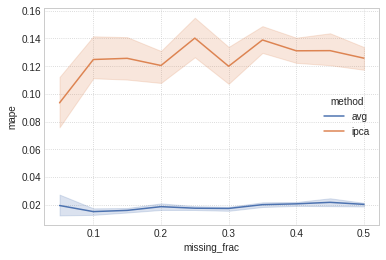

In [101]:
sns.lineplot(data=results, x='missing_frac', y='mape', hue='method')

In [77]:
ipca = IPCA(maxiter=50000)
ipca.fit(train_data.values)

ipca.explained_variance_ratio

array([0.79890828, 0.93592066, 0.9572234 , 0.97318553, 0.98099181,
       0.98817433, 0.99171227, 0.99390147, 0.99567101, 0.99699736])

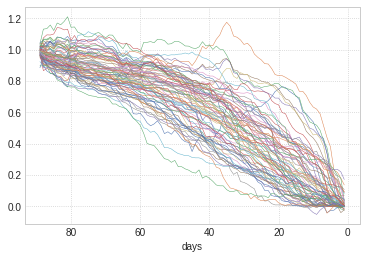

In [78]:
train_data_filled = pd.DataFrame(ipca.x_filled, index=train_data.index, columns=train_data.columns)

train_data_filled.T.plot(legend=False, lw=0.5)

plt.gca().invert_xaxis()

In [79]:
missing_frac = train_data.isna().mean(axis=1).sort_values(ascending=False)
missing_frac.head(2)

date
2021-04-12    0.786517
2021-04-13    0.775281
dtype: float64

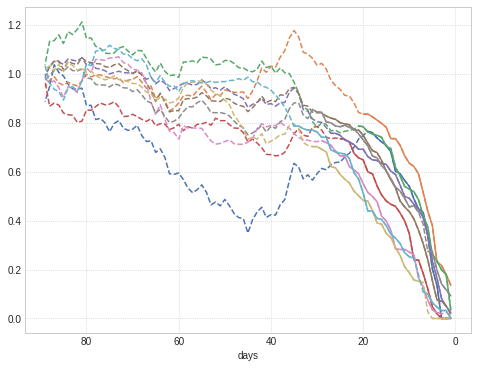

In [80]:
idx = missing_frac.index[:10]

plt.figure(figsize=(8, 6))

for i, date in enumerate(idx):
    train_data.loc[date].plot(c=f'C{i}')
    train_data_filled.loc[date].plot(ls='dashed', c=f'C{i}')
    
plt.gca().invert_xaxis()

plt.savefig(figures_dir / 'ipca_filled.pdf', transparent=True, bbox_inches='tight')

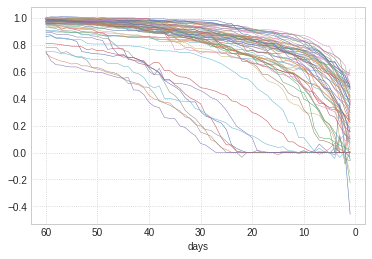